In [2]:
library(ggplot2)
library(ChIPseeker)
library(GenomicFeatures)
library(tidyverse)
library(ggvenn)
library(cowplot)
library(patchwork)
library(ggsci)
library(ggplotify)
library(clusterProfiler)
library(readxl)
library(DESeq2)
library(ggrepel)
library(ggupset)
library(UpSetR)

In [3]:
txdb <- makeTxDbFromGFF(file = "genome//SS.gtf", format = "gtf")

Warning message in call_fun_in_txdbmaker("makeTxDbFromGFF", ...):
"makeTxDbFromGFF() has moved from GenomicFeatures to the txdbmaker package,
  and is formally deprecated in GenomicFeatures >= 1.59.1. Please call
  txdbmaker::makeTxDbFromGFF() to get rid of this warning."
Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .makeTxDb_normarg_chrominfo(chrominfo):
"genome version information is not available for this TxDb object"
OK



In [4]:
eqtl <- read.table("05_pQTL/F1_pQTL_results.txt",header=T)

In [5]:
feature <- eqtl %>%
        arrange(p.value) %>%
        head(5000) %>%
    mutate(CHROM=str_extract(SNP,"(\\w+):")) %>%
    mutate(CHROM=gsub(":","",CHROM)) %>%
    mutate(Pos=str_extract(SNP,":(\\w+)")) %>%
    mutate(Pos=gsub(":","",Pos)) %>%
    mutate(Start=as.numeric(Pos)) %>%
    mutate(End=as.numeric(Pos)) %>%
    dplyr::select(CHROM,Start,End,SNP)

In [6]:
#write.table(feature,"05_pQTL/top5000.SNP",quote=F,row.names=F,sep="\t")

In [7]:
peak <- readPeakFile('05_pQTL/top5000.SNP')

In [8]:
peakAnno <- annotatePeak(peak, tssRegion = c(-3000, 3000), TxDb = txdb)

>> preparing features information...		 2025-11-26 16:15:37 
>> identifying nearest features...		 2025-11-26 16:15:38 
>> calculating distance from peak to TSS...	 2025-11-26 16:15:38 
>> assigning genomic annotation...		 2025-11-26 16:15:38 
>> assigning chromosome lengths			 2025-11-26 16:15:42 
>> done...					 2025-11-26 16:15:42 


Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


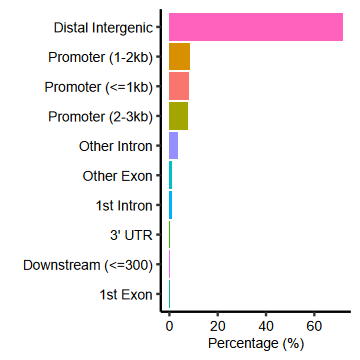

In [9]:
options(repr.plot.width=3, repr.plot.height=3)
Figure3A <- peakAnno@annoStat %>%
    ggplot(aes(reorder(Feature,Frequency),Frequency,fill=Feature))+
        geom_bar(stat='identity')+
    theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),
              panel.background = element_blank(),
          legend.position="none",
             axis.line = element_line(colour = "black",size = 0.5))+
    coord_flip()+xlab("")+ylab("Percentage (%)")
Figure3A

In [10]:
TSS <- data.frame(peakAnno)

In [11]:
TSS %>%
    dplyr::filter(geneId %in% c('EVM0023416','EVM0010743'))

seqnames,start,end,width,strand,SNP,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS
<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>
Chr15,12382330,12382329,0,*,Chr15:12382329,Distal Intergenic,15,12397914,12400328,2415,1,EVM0023416,EVM0023416.1,-15585
Chr04,15071689,15071688,0,*,Chr04:15071688,Distal Intergenic,4,15065593,15067094,1502,1,EVM0010743,EVM0010743.1,6096


Joining with `by = join_by(SNP)`


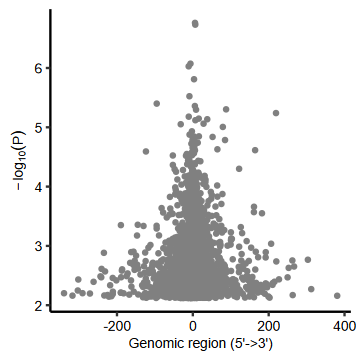

In [12]:
options(repr.plot.width=3, repr.plot.height=3)
Figure3B <- TSS %>%
    dplyr::select(SNP,transcriptId,distanceToTSS) %>%
    inner_join(eqtl) %>%
    mutate(distanceToTSS=distanceToTSS/1000) %>%
    ggplot(aes(distanceToTSS,-log10(p.value)))+
        geom_point(size=0.8,color='#808080')+
    theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),
              panel.background = element_blank(),
          legend.position="none",
             axis.line = element_line(colour = "black",size = 0.5))+
xlab("Genomic region (5'->3')")+
ylab(expression(-log[10](P)))
Figure3B

In [13]:
QTL.gene <- read.table("03_vcf//Fst//QTL.gene")
QTL.gene <- unique(QTL.gene$V7)
QTL.gene <- lapply(QTL.gene,function(x){
    gene <- unlist(str_split(x,"\\."))[1]
})
QTL.gene <- unlist(QTL.gene)

In [14]:
Fst_top5.gene <- read.table("03_vcf//Fst//Fst_top5.gene")
Fst_top5.gene <- unique(Fst_top5.gene$V7)
Fst_top5.gene <- lapply(Fst_top5.gene,function(x){
    gene <- unlist(str_split(x,"\\."))[1]
})
Fst_top5.gene <- unlist(Fst_top5.gene)

In [15]:
#write.table(unique(TSS$transcriptId),"05_pQTL/pQTL.gene",quote=F,row.names=F,sep="\t")

In [16]:
DEG <- function(count,sampleNames,comparison,rep=3){
    data <- count[,sampleNames]
    countData <- as.matrix(data)
    condition <- c(rep("control",rep),rep("treatment",rep))
    database <- data.frame(name=sampleNames, condition=condition)
    database$condition <- factor(database$condition)
    rownames(database) <- sampleNames
    dds <- DESeqDataSetFromMatrix(countData, colData=database, design= ~ condition)
    dds <- dds[ rowSums(counts(dds)) > 10, ]
    dds <- DESeq(dds)
    res <- results(dds,contrast=c("condition", "treatment", "control"))
    res <- res %>%
        as.data.frame() %>%
        mutate(comparison=comparison,gene=rownames(res))
    return(res)
}

In [17]:
count <- read.table("06_counts/Loquat_ZP.counts",header=T,check.names=F)

In [18]:
count <- count %>%
    dplyr::select(-c(Chr,Start,End,Strand,Length))

In [19]:
rownames(count) <- count$Geneid
count <- count[,-1]

In [20]:
S1 <- DEG(count=count,
    sampleNames= c("ZP44-S1_1","ZP44-S1_2","ZP44-S1_3","ZP65-S1_1","ZP65-S1_2","ZP65-S1_3"),
    comparison=c("S1"))

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [21]:
S2 <- DEG(count=count,
    sampleNames= c("ZP44-S2_1","ZP44-S2_2","ZP44-S2_3","ZP65-S2_1","ZP65-S2_2","ZP65-S2_3"),
    comparison=c("S2"))

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [22]:
S4 <- DEG(count=count,
    sampleNames= c("ZP44-S4_1","ZP44-S4_2","ZP44-S4_3","ZP65-S4_1","ZP65-S4_2","ZP65-S4_3"),
    comparison=c("S4"))

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [23]:
S6 <- DEG(count=count,
    sampleNames= c("ZP44-S6_1","ZP44-S6_2","ZP44-S6_3","ZP65-S6_1","ZP65-S6_2","ZP65-S6_3"),
    comparison=c("S6"))

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [24]:
S8 <- DEG(count=count,
    sampleNames= c("ZP44-S8_1","ZP44-S8_2","ZP44-S8_3","ZP65-S8_1","ZP65-S8_2","ZP65-S8_3"),
    comparison=c("S8"))

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [25]:
fdr <- 0.05
log2FC <- 1

In [26]:
DEGs <- rbind(S1,S2,S4,S6,S8) %>%
    dplyr::filter(!is.na(padj)) %>%
    dplyr::filter(!is.na(pvalue)) %>%
    mutate(group=case_when(
        log2FoldChange > log2FC & padj < fdr ~ "Up",
        log2FoldChange < -log2FC & padj < fdr ~ "Down",
        TRUE ~ 'None'
))

In [29]:
DEGs_sub <- DEGs[DEGs$group!='None',]

In [32]:
#write.csv(DEGs_sub,"Tables//Table S3.csv",quote=F,row.names=F)

In [35]:
#save(DEGs,file="06_counts/DEGs.RData")

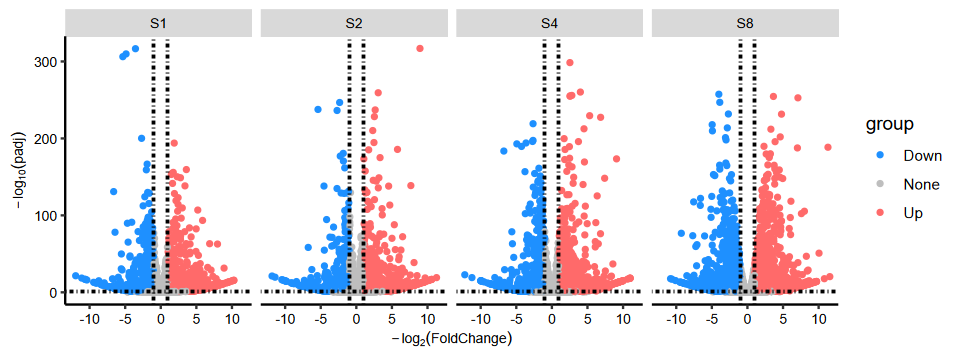

In [37]:
options(repr.plot.width=8, repr.plot.height=3)
FigureS3A <- DEGs %>%
    dplyr::filter(padj>0) %>%
    dplyr::filter(comparison!="S6") %>%
    ggplot(aes(x = log2FoldChange, y = -log10(padj), colour=group)) +
    geom_point(size=1) +
    scale_color_manual(values=c("DodgerBlue1",'grey','IndianRed1'))+
    geom_vline(xintercept=c(-1,1),lty=4,col="black",lwd=0.8) +
    geom_hline(yintercept = -log10(0.05),lty=4,col="black",lwd=0.8) +
    facet_wrap(~comparison,ncol=4)+
    theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),
               axis.text.x = element_text(angle=0),
              panel.background = element_blank(),
              legend.position='right',strip.text = element_text(size = 8, colour = "black"),
              #strip.background = element_rect(color="white",fill='white'),
             axis.line = element_line(colour = "black",size = 0.5))+
ylab(expression(-log[10](padj)))+xlab(expression(-log[2](FoldChange)))
FigureS3A

In [76]:
DEGs %>%
    dplyr::filter(group!="None") ->ll

In [77]:
length(unique(ll$gene))

[1] 11199

In [38]:
overlap_gene <- DEGs %>%
    dplyr::filter(group!="None") %>%
    dplyr::select(gene,comparison) %>%
    mutate(Number=TRUE) %>%
    spread(.,comparison,Number)

In [39]:
overlap_gene[is.na(overlap_gene)] <- FALSE

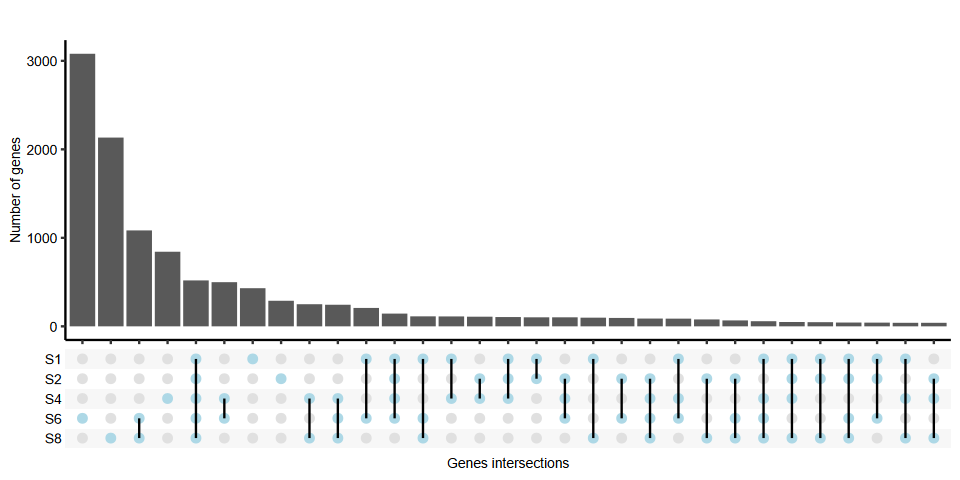

In [50]:
# 转换数据格式
data_long <- overlap_gene %>%
  pivot_longer(cols = -gene, names_to = "set", values_to = "member") %>%
  filter(member) %>%
  group_by(gene) %>%
  summarise(sets = list(set))
# 创建UpSet图
options(repr.plot.width=8, repr.plot.height=4)
FigureS3B <- ggplot(data_long, aes(x = sets)) +
  geom_bar() +
  scale_x_upset(sets = c("S1", "S2", "S4", "S6","S8")) +
  labs(
    title = "",
    x = "Genes intersections",
    y = "Number of genes"
  ) +
    theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),
               axis.text.x = element_text(angle=0),
              panel.background = element_blank(),
              legend.position='right',strip.text = element_text(size = 8, colour = "black"),
              #strip.background = element_rect(color="white",fill='white'),
             axis.line = element_line(colour = "black",size = 0.5))+
theme_combmatrix(combmatrix.label.text = element_text(color = "black", size=8),
                combmatrix.panel.point.color.fill = "lightblue",
                 combmatrix.panel.point.size = 2,
                combmatrix.panel.line.size = 0.5)
FigureS3B

Warning message:
"`aes_()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`
ℹ The deprecated feature was likely used in the ggplotify package.
  Please report the issue at <https://github.com/GuangchuangYu/ggplotify/issues>."


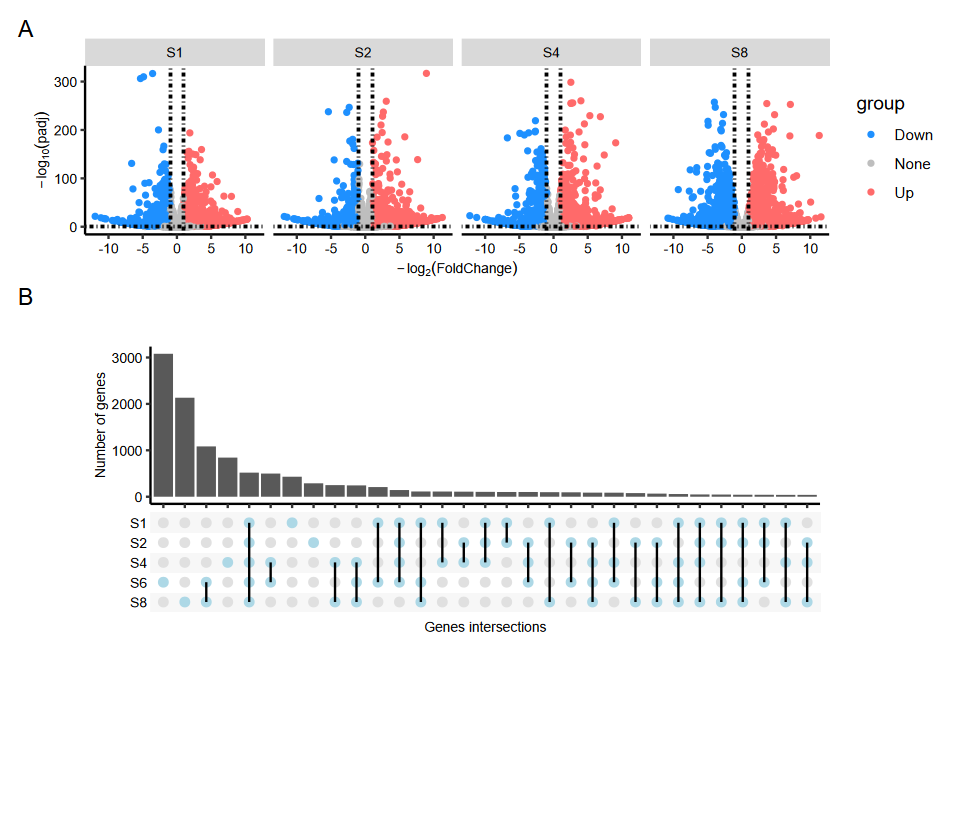

In [41]:
options(repr.plot.width=8, repr.plot.height=7)
(FigureS3A/as.ggplot(FigureS3B)/plot_spacer())+plot_layout(height=c(1,2,1))+plot_annotation(tag_levels='A')

In [42]:
#pdf("Figures\\Figure S3.pdf",width=8,height=7)
#(FigureS3A/as.ggplot(FigureS3B)/plot_spacer())+plot_layout(height=c(1,2,1))+plot_annotation(tag_levels='A')
#dev.off()

pdf 
  2

In [32]:
gene.bed <- read.table("genome//SS_gene.bed")

In [33]:
gene.bed <- gene.bed %>%
    dplyr::select(gene=V1,Chr=V2)

In [34]:
deg <- S6 %>%
    dplyr::filter(!is.na(padj)) %>%
    dplyr::filter(!is.na(pvalue)) %>%
    inner_join(gene.bed) %>%
    mutate(sig = ifelse(padj<0.05,'padj < 0.05','padj > 0.05')) %>%
    mutate(reg = ifelse(log2FoldChange< -1,'down',ifelse(log2FoldChange>1,'up','none')))

Joining with `by = join_by(gene)`


In [35]:
chr <- sort(unique(deg$Chr))

In [36]:
dfcol <- data.frame(Chr=chr,labelcol=rev(c("#9370DB","#483D8B","#B0C4DE",
                                   "#4169E1","#4682B4","#5F9EA0","#00CED1","#008080","#3CB371","#BDB76B","#FFD700",
                                   "#FFA500","#800000",'#3A97CA','#5CB8EA','#F1E648',"#F14A48")))

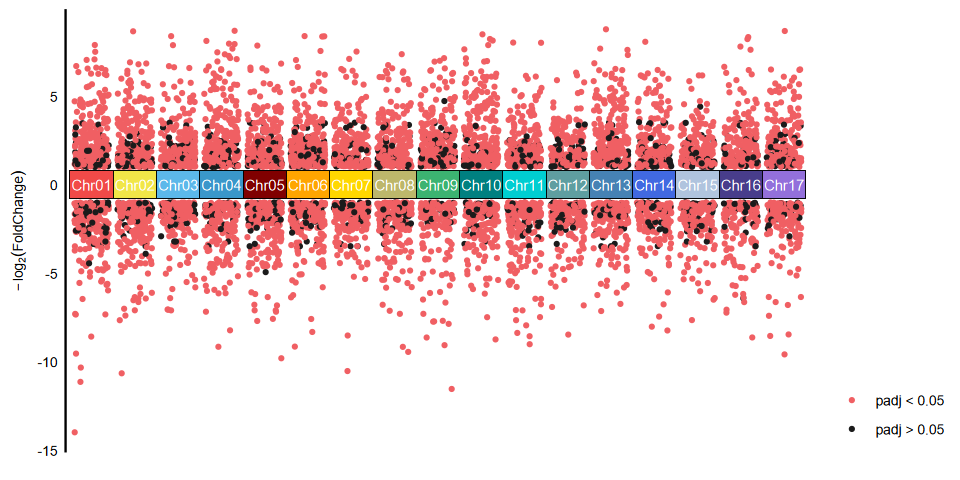

In [38]:
options(repr.plot.width=8, repr.plot.height=4)
Figure3D <- deg %>%
    dplyr::filter(abs(log2FoldChange)>1) %>%
    ggplot(aes(Chr,log2FoldChange,color=sig)) +
    geom_jitter(size = 0.7, width =0.4)+
    scale_color_manual(name=NULL, values = c("#f05f63","#1b1b1b"))+
    xlab("")+
    geom_tile(data = dfcol, aes(x=Chr,y=0), height=1 * 2 * 0.8, color = "black", fill = dfcol$labelcol,  show.legend = F) + 
    geom_text(data=dfcol, aes(x=Chr,y=0,label=Chr), size =3, color = 'white')+
theme_minimal()+
  theme( axis.title = element_text(size = 8, color = "black",face = "bold"),
    axis.line.y = element_line(color = "black",size = 0.5),
    axis.line.x = element_blank(),
    axis.text.x = element_blank(),axis.text=element_text(size=8,color='black'),
    panel.grid = element_blank(),
    legend.position = "none",
    legend.direction = "vertical",
    legend.justification = c(1,0),
    legend.text = element_text(size = 8)
    )+
ylab(expression(-log[2](FoldChange)))
Figure3D

In [39]:
KOannotation <- read.delim("GO/SS_GOannotation.tsv", stringsAsFactors=FALSE)
genes <- lapply(KOannotation$gene,function(x){
    gene <- unlist(str_split(x,"\\."))[1]
    }
    )
KOannotation$gene <- unlist(genes)
KOinfo <- read.delim("GO//go.tb", stringsAsFactors=FALSE)
KOannotation = split(KOannotation, with(KOannotation, level))
KOkegg <- read.delim("KEGG/SS_KOannotation.tsv", stringsAsFactors=FALSE)
genes <- lapply(KOkegg$gene,function(x){
    gene <- unlist(str_split(x,"\\."))[1]
    }
    )
KOkegg$gene <- unlist(genes)

In [40]:
deg2 <- deg %>%
    dplyr::filter(padj<0.05 & abs(log2FoldChange)>1)

In [41]:
GO_result <- NULL
for(j in c("biological_process","cellular_component","molecular_function")){
    print(j)
    ego <- enricher(deg2$gene,TERM2GENE=KOannotation[[j]][c(2,1)],TERM2NAME=KOinfo[1:2])
    ego <- data.frame(ego)
    ego <- ego[ego$p.adjust<0.05,]
    if(nrow(ego)==0){
        next
    }
    ego$enrichment <- j 
    GeneRatio <- lapply(ego$GeneRatio,function(x){
        x <- as.numeric(unlist(str_split(x,"/")))
        r <- x[1]/x[2]
    })
    ego$Ratio <- unlist(GeneRatio)
    ego <- ego %>%
                arrange(pvalue) %>%
                head(5)
    GO_result <- rbind(GO_result,ego)
} 

[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"


In [42]:
kegg <- enricher(deg2$gene,TERM2GENE=KOkegg[c(3,1)],TERM2NAME=KOkegg[c(3,4)])

In [43]:
kegg <- data.frame(kegg)
kegg <- kegg[kegg$p.adjust<0.05,]
kegg$enrichment <- "KEGG"
generatio <- lapply(kegg$GeneRatio,function(x){
            x <- as.numeric(unlist(str_split(x,"/")))
            r <- x[1]/x[2]
        })
kegg$Ratio <- unlist(generatio)

In [44]:
kegg <- kegg[1:5,]

In [45]:
Enrich <- rbind(GO_result,kegg)  %>%
        arrange(enrichment,Ratio)

In [46]:
#write.csv(Enrich,"06_counts/S6_enrich.csv",row.names=F)

In [47]:
Enrich <- read.csv("06_counts/S6_enrich.csv")

In [48]:
colors <- data.frame(enrichment=c('biological_process','cellular_component','molecular_function','KEGG'),
          fill_color=c('#FFDDDD','#DDDDFF','#DDFFDD','#E3BFD9'))

In [49]:
background_data <- Enrich %>%
                    mutate(inx=1:nrow(Enrich)) %>%
        group_by(enrichment) %>%
        summarise(xmin=min(inx)-0.5,xmax=max(inx)+0.5) %>%
        inner_join(colors)

Joining with `by = join_by(enrichment)`


In [50]:
tmp2 <- Enrich %>%
                mutate(inx=1:nrow(Enrich)) %>%
                mutate(inx=factor(inx))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


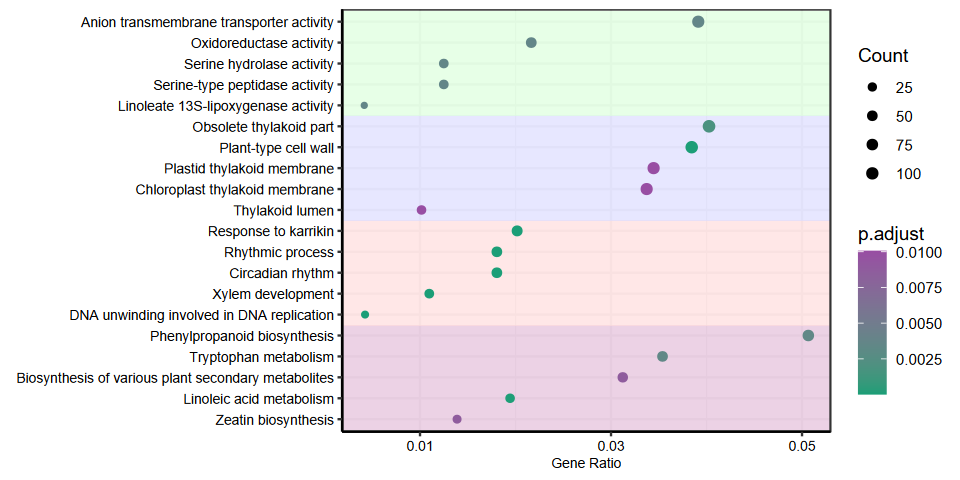

In [51]:
options(repr.plot.width=8, repr.plot.height=4)
Figure3F <- ggplot()+
            geom_rect(
                data = background_data,
                aes(xmin = xmin, xmax = xmax, ymin = -Inf, ymax = Inf, fill = I(fill_color)),
                alpha = 0.7
              )+
            geom_point(data=tmp2,aes(inx,Ratio,size=Count,color=p.adjust))+scale_size(range = c(1, 2.5))+
                        theme_bw()+
                        theme(axis.line = element_line(colour = "black",linewidth = 0.5),
                              strip.background =element_rect(colour = NA,fill = NA,linewidth = 1),
                        axis.text=element_text(size=8,color='black'),axis.title=element_text(size=8),
                        legend.position='right')+
                        coord_flip()+
                        xlab("")+
                        scale_color_gradient(low="blue",high="red")+
                        ylab('Gene Ratio')+scale_color_gradient(low = "#1B9E77", high = "#984EA3")+
                        #scale_x_discrete(labels = function(x) str_wrap(x, width = 100))+
    scale_x_discrete(breaks=1:nrow(Enrich),labels=Enrich$Description)+
    scale_y_continuous(breaks=c(0.01,0.03,0.05),labels=c(0.01,0.03,0.05))
Figure3F

In [52]:
pQTL.gene <- unique(TSS$transcriptId)
pQTL.gene <- lapply(pQTL.gene,function(x){
    gene <- unlist(str_split(x,"\\."))[1]
})
pQTL.gene <- unlist(pQTL.gene)

In [53]:
geneSets <- list()
geneSets[["DEGs"]] <- unique(deg2$gene)
geneSets[["QTL genes"]] <- QTL.gene
geneSets[["Fst top 5% genes"]] <- unique(Fst_top5.gene)
geneSets[["pQTL genes"]] <- pQTL.gene

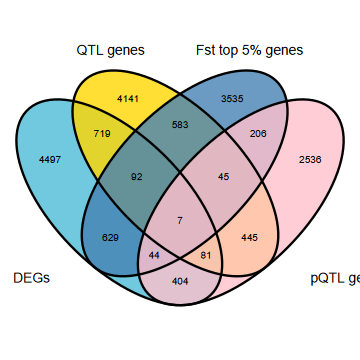

In [54]:
options(repr.plot.width=3, repr.plot.height=3)
Figure3E <- ggvenn(
  geneSets, 
  fill_color = c("#4dbbd5", "gold", "SteelBlue",'pink'),
  stroke_size = 0.5,show_percentage=FALSE,fill_alpha = 0.8,
  set_name_size = 2.8,text_size=2
)
Figure3E

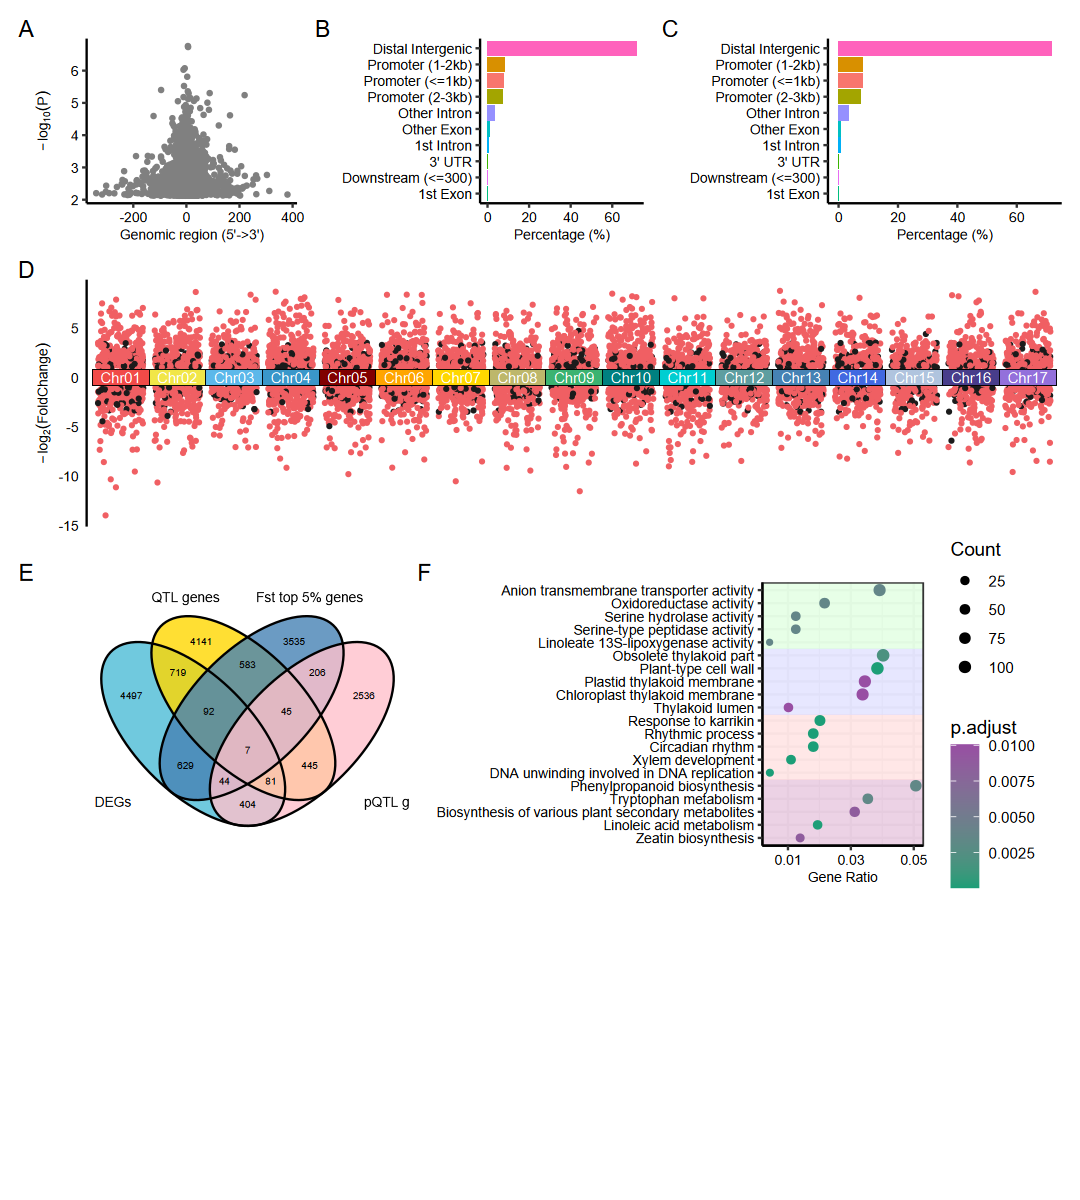

In [55]:
options(repr.plot.width=9, repr.plot.height=10)
(((Figure3B|Figure3A|Figure3A)+plot_layout(width=c(1.8,1.4,2)))/Figure3D/
 ((Figure3E|Figure3F|plot_spacer())+plot_layout(width=c(2,1,0)))/plot_spacer())+
plot_layout(height=c(1,1.5,1.6,1.7))+plot_annotation(tag_levels='A')

In [56]:
#pdf("Figures\\Figure 3.pdf",width=9,height=10)
#(((Figure3B|Figure3A|Figure3A)+plot_layout(width=c(1.8,1.4,2)))/Figure3D/
#((Figure3E|Figure3F|plot_spacer())+plot_layout(width=c(2,1,0)))/plot_spacer())+
#plot_layout(height=c(1,1.5,1.6,1.7))+plot_annotation(tag_levels='A')
#dev.off()